In [1]:
# Jypyter notebook specific
%matplotlib inline
from IPython.display import display, HTML

# Standard imports
import logging
import glob
import os

# Dependecy imports
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import numpy as np

import keras.backend.tensorflow_backend as K

K_CONFIG = K.tf.ConfigProto()
K_CONFIG.allow_soft_placement = True
K_CONFIG.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=K_CONFIG))

Using TensorFlow backend.


In [2]:
CWD = '/home/nauris/Dropbox/coding/detect_weather/weather_dataset/'

other = glob.glob(CWD + 'Other/**.jpg')
sniegs = glob.glob(CWD + 'Sniegs/**.jpg')
migla = glob.glob(CWD + 'Migla/**.jpg')

print('other', len(other))
print('sniegs', len(sniegs))
print('migla', len(migla))

other 231
sniegs 92
migla 55


In [3]:
train_paths = sniegs + migla + other
labels = [[1, 0, 0]] * len(sniegs) + [[0, 1, 0]] * len(migla) + [[0, 0, 1]] * len(other)

print('Train paths', len(train_paths))
print('labels', len(labels))

Train paths 378
labels 378


# Load images

In [4]:
import cv2
import numpy as np

In [5]:
height = 200 # Resize to this height
width_0 = 370 # Pad zero pixels to get same width for all images

def load_images(im_paths):

    images = []
    for path in im_paths:

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        width = int(height * img.shape[1] / img.shape[0])
        img_res = cv2.resize(img, (width, height))

        img_res = np.pad(img_res, ((0, 0), (0, width_0 - width), (0, 0)),
                         'constant', constant_values=0)

        images.append(img_res)
    
    images = np.asarray(images)
    
    return images

images = load_images(train_paths)

In [6]:
print(images.shape, images.dtype)

labels = np.asarray(labels)
print(labels.shape, labels.dtype)

images, labels = shuffle(images, labels)

(378, 200, 370, 3) uint8
(378, 3) int64


In [7]:
def normalize(imgs):

    imgs = (imgs - 127.5) / 255
    # imgs = imgs - imgs.mean()
    
    return imgs

images = normalize(images)
print(images.max(), images.min(), images.mean())

0.5 -0.5 -0.0652475440894


In [8]:
test_images = images[0:10]
test_labels = labels[0:10]
images = images[11:]
labels = labels[11:]

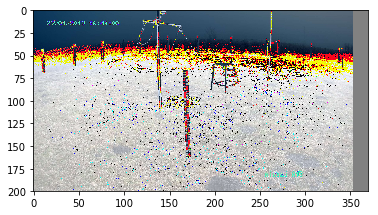

[0 1 0]


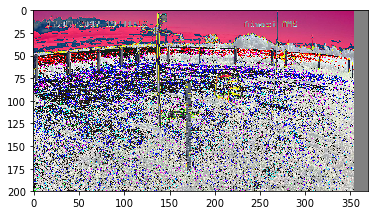

[0 0 1]


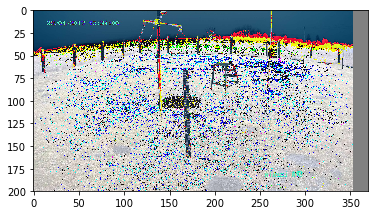

[0 1 0]


In [9]:
plt.imshow(images[20])
plt.show()
print(labels[20])
plt.imshow(images[50])
plt.show()
print(labels[50])
plt.imshow(images[100])
plt.show()
print(labels[100])

# Train model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import adam
from keras.utils.data_utils import Sequence

In [19]:
activation = 'relu'

def model(dshape):
    seq_model = Sequential()

    # seq_model.add(BatchNormalization(input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(24, (5, 5), padding='valid',
                  activation=activation, strides=(2, 2),
                  input_shape=(dshape[0], dshape[1], dshape[2])))
    seq_model.add(Conv2D(36, (5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.8))
    seq_model.add(Conv2D(48,(5, 5), padding='valid', activation=activation, strides=(2, 2)))
    seq_model.add(Dropout(0.8))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Dropout(0.8))
    seq_model.add(Conv2D(64, (3, 3), padding='valid', activation=activation))
    seq_model.add(Flatten())
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(100, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(50, activation=activation))
    seq_model.add(Dropout(0.5))
    seq_model.add(Dense(10, activation=activation))
    seq_model.add(Dense(3, activation='softmax'))
    seq_model.compile(loss='categorical_crossentropy', optimizer=adam(0.001), metrics=['accuracy'])
    seq_model.summary()

    return seq_model

In [20]:
keras_model = model((height, width_0, 3))  # creates model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 183, 24)       1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 90, 36)        21636     
_________________________________________________________________
dropout_7 (Dropout)          (None, 47, 90, 36)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 22, 43, 48)        43248     
_________________________________________________________________
dropout_8 (Dropout)          (None, 22, 43, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 41, 64)        27712     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 41, 64)        0         
__________

In [26]:
keras_model.fit(images, labels, epochs=25, batch_size=8, shuffle=True, validation_split=None, verbose=1)

Epoch 1/25
367/367 [==============================] - 1s - loss: 0.0233 - acc: 0.9918     
Epoch 2/25
367/367 [==============================] - 1s - loss: 0.0714 - acc: 0.9864     
Epoch 3/25
367/367 [==============================] - 1s - loss: 0.0864 - acc: 0.9891     
Epoch 4/25
367/367 [==============================] - 1s - loss: 0.4494 - acc: 0.9700     
Epoch 5/25
367/367 [==============================] - 1s - loss: 0.2244 - acc: 0.9673     
Epoch 6/25
367/367 [==============================] - 1s - loss: 0.0742 - acc: 0.9864     
Epoch 7/25
367/367 [==============================] - 1s - loss: 0.0711 - acc: 0.9891     
Epoch 8/25
367/367 [==============================] - 1s - loss: 0.0690 - acc: 0.9891     
Epoch 9/25
367/367 [==============================] - 1s - loss: 0.0713 - acc: 0.9891     - ETA: 0s - loss: 0.0756 - acc: 0.988
Epoch 10/25
367/367 [==============================] - 1s - loss: 0.0277 - acc: 0.9918     
Epoch 11/25
367/367 [==============================]

# Test Model

In [27]:
test_res = keras_model.evaluate(test_images, test_labels, batch_size=100)

loss = test_res[0]
acc = test_res[1]

print('loss', loss, 'acc', acc)

10/10 [==============================] - 0s
loss 0.121366128325 acc 1.0


# Save model

In [28]:
def save_keras_model(save_model, path):
    """Save keras model to given path."""
    save_model.save_weights(path + 'model.h5')

    with open(path + 'model.json', "w") as text_file:
        text_file.write(save_model.to_json())

    logging.info('Keras json model saved. %s', path + 'model.json')
    logging.info('Keras h5 model saved. %s', path + 'model.h5')

In [29]:
save_path = "model/keras_"
save_keras_model(keras_model, save_path)

# Test on google images

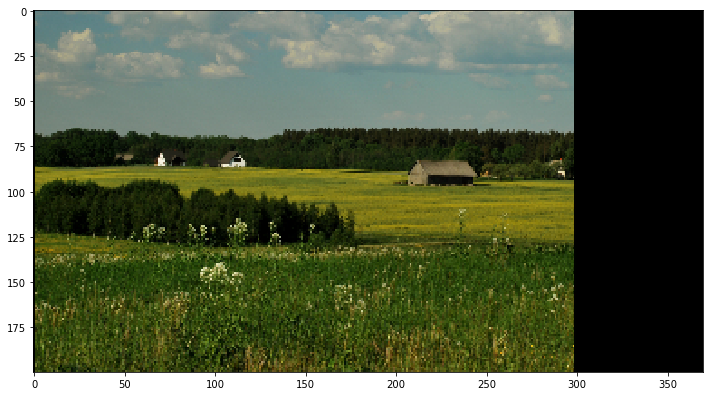

[[  5.15966667e-06   5.24780189e-04   9.99470055e-01]] cits


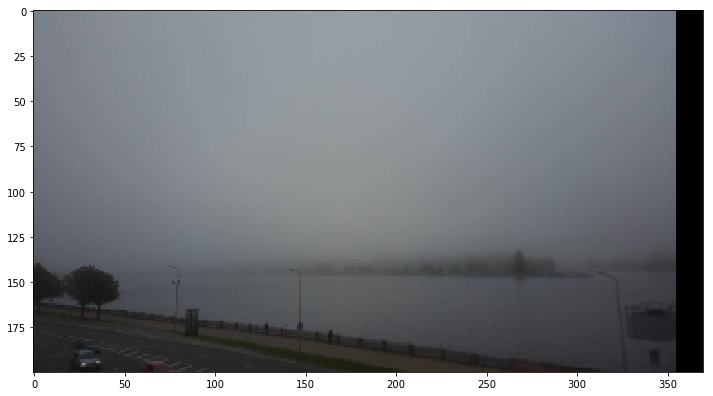

[[ 0.15254708  0.70030528  0.14714772]] migla


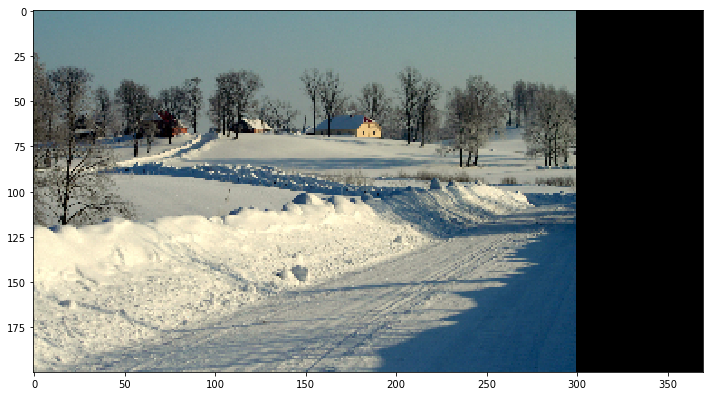

[[ 0.07577268  0.28293237  0.64129502]] cits


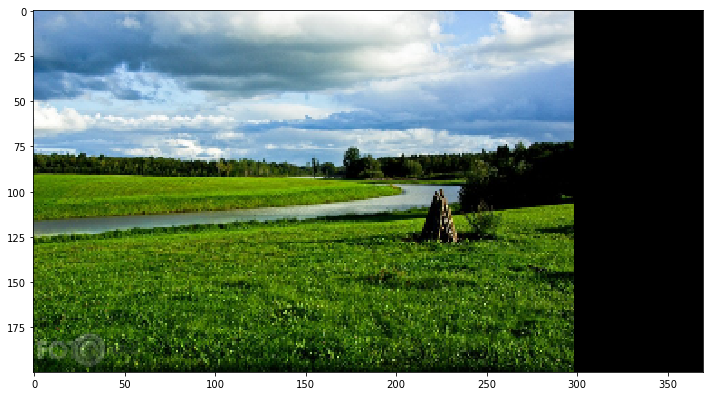

[[  3.61022603e-06   9.99983788e-01   1.26511504e-05]] migla


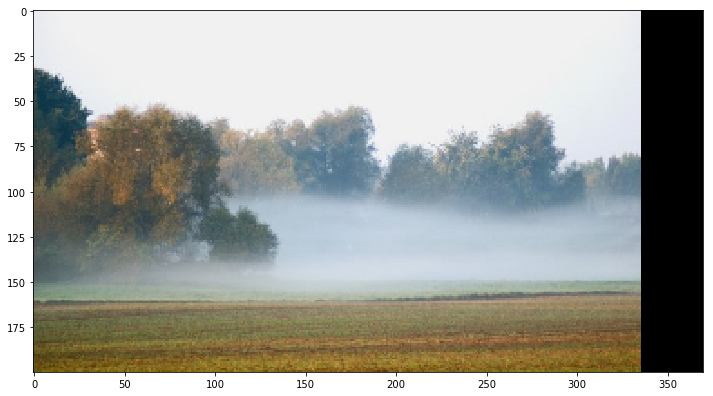

[[ 0.55414987  0.298069    0.14778109]] sniegs


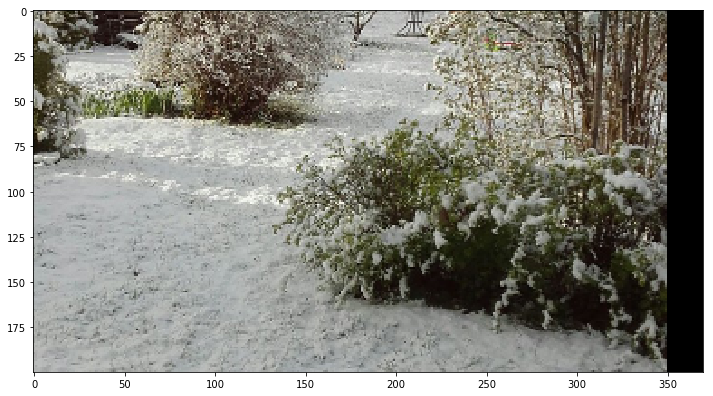

[[ 0.89063048  0.07799315  0.0313764 ]] sniegs


In [30]:
classes = {0: 'sniegs', 1: 'migla', 2: 'cits'}
google_im_paths = glob.glob('/home/nauris/Dropbox/coding/detect_weather/daba/*.jpg')

for im_path in google_im_paths:
    im = load_images([im_path])
    
    plt.figure(figsize=(12,8))
    plt.imshow(im[0])
    plt.show()
    
    im_norm = normalize(im)
    preds = keras_model.predict(im_norm)
    print(preds, classes[np.argmax(preds[0])])